## Data Preprocessing

In [2]:
# loading libraries
import librosa   #for audio processing
import librosa.display
import wave
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sys
import json
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [3]:
# loading scripts
sys.path.insert(1, '../scripts')
sys.path.append("..")
sys.path.append(".")

from data_cleaning import DataCleaner
from data_viz import Data_Viz

DC = DataCleaner("../logs/preprocessing_notebook.log")
DV = Data_Viz()

## Load metadata

In [4]:
# loading meta data
path = "../data/train"
output = "../data/train_new"

meta_data = DC.generate_metadata(path, output)
meta_data.head()


,Target,Feature,Output
0,ያንደኛ ደረጃ ትምህርታቸው ን ጐንደር ተ ም ረዋል,../data/train/wav/tr_1_tr01001.wav,../data/train_new/tr_1_tr01001.wav
1,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖ...,../data/train/wav/tr_2_tr01002.wav,../data/train_new/tr_2_tr01002.wav
2,በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ ...,../data/train/wav/tr_3_tr01003.wav,../data/train_new/tr_3_tr01003.wav
3,ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው,../data/train/wav/tr_4_tr01004.wav,../data/train_new/tr_4_tr01004.wav
4,ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች,../data/train/wav/tr_5_tr01005.wav,../data/train_new/tr_5_tr01005.wav


In [5]:
# adding duration column

DC.add_duration(meta_data)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

,Target,Feature,Output,Duration
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,10.368
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,14.592
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,7.936
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,6.528
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,6.528


## Spectogramm

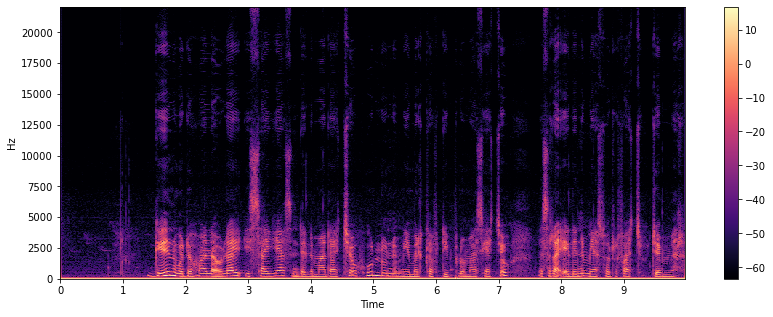

In [6]:
samples, sample_rate = librosa.load('../data/train_new/tr_10_tr01010.wav', sr=None)
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

## Standardize Sampling Rate

In [7]:
# checking rate before standardizing

data =  wave.open('../data/train/wav/tr_10_tr01010.wav')
data.getparams().framerate

16000

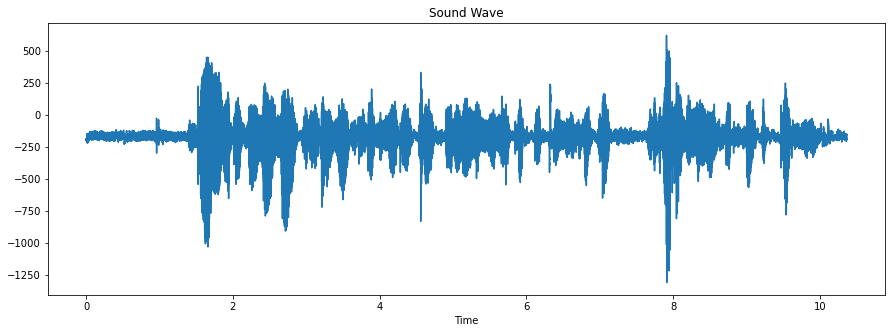

In [7]:
DV.visualize('../data/train/wav/tr_10_tr01010.wav')

In [8]:
DC.standardize(meta_data, 44100)

In [9]:
# checking rate after standardizing 
data =  wave.open('../data/train_new/tr_10_tr01010.wav')
data.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=457227, comptype='NONE', compname='not compressed')

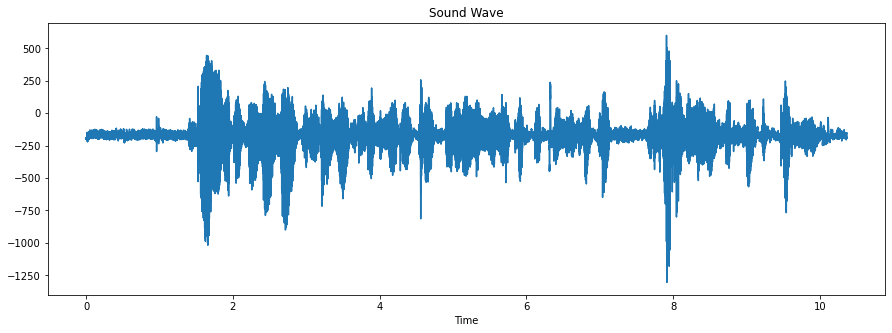

In [10]:
DV.visualize('../data/train_new/tr_10_tr01010.wav')

**Observation**
- sample rates have been sucessfully standardized
- framrate = 44100


## Resizing Audio Samples

In [11]:
# checking duration before resizing

meta_data= DC.add_duration(meta_data, output= True)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

,Target,Feature,Output,Duration
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,10.367959
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,14.591950
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,7.935941
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,6.527959
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,6.527959


In [12]:
max_dur = DC.get_max_dur(meta_data)
DC.resize_pad_trunc(meta_data, 10000)

maximum duration: 19.0


In [13]:
# checking truncated result
meta_data= DC.add_duration(meta_data, output= True)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

,Target,Feature,Output,Duration
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,9.977324
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,9.977324
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,9.977324
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,9.977324
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,9.977324


## Convert Mono to Stereo

In [14]:
# adding new column for channels count

meta_data= DC.channel_count(meta_data)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

,Target,Feature,Output,Duration,n_channel
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,9.977324,1
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,9.977324,1
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,9.977324,1
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,9.977324,1
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,9.977324,1


In [15]:
# checking number of channels

meta_data["n_channel"].value_counts()

400    9875
1      1000
Name: n_channel, dtype: int64

**Observation**
- All the loadded audio samples are mono
- 400 is just a placeholder for missing audio files 
  because only a limited number of samples are taken for development
  This will not be present when the data is complete.

In [16]:
# Converting to stereo

DC.make_stereo(meta_data, True)

In [17]:
# making sure everything is right
data =  wave.open('../data/train_new/tr_10_tr01010.wav')
print("the parameters are: ", data.getparams())
meta_data= DC.add_duration(meta_data, output= True)
meta_data= DC.channel_count(meta_data, output= True)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()


the parameters are:  _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=440000, comptype='NONE', compname='not compressed')


,Target,Feature,Output,Duration,n_channel
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,9.977324,2
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,9.977324,2
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,9.977324,2
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,9.977324,2
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,9.977324,2


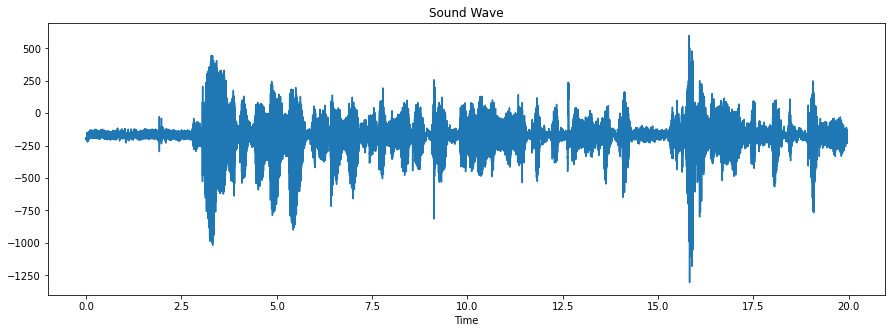

In [18]:
DV.visualize('../data/train_new/tr_10_tr01010.wav')

**Observation**
- audio samples have been successfully converted to stereo
- 400 is just a placeholder for missing audio files 
  because only a limited number of samples are taken for development
  This will not be present when the data is complete.

## Data Augumentation
### Time Shift

In [ ]:
DC.time_shift(meta_data, int(sample_rate/10), True)

In [19]:
# making sure everything is right
data =  wave.open('../data/train_new/tr_10_tr01010.wav')
print("the parameters are: ", data.getparams())
meta_data= DC.add_duration(meta_data, output= True)
meta_data= DC.channel_count(meta_data, output= True)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

the parameters are:  _wave_params(nchannels=2, sampwidth=2, framerate=44100, nframes=440000, comptype='NONE', compname='not compressed')


,Target,Feature,Output,Duration,n_channel
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,9.977324,2
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,9.977324,2
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,9.977324,2
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,9.977324,2
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,9.977324,2


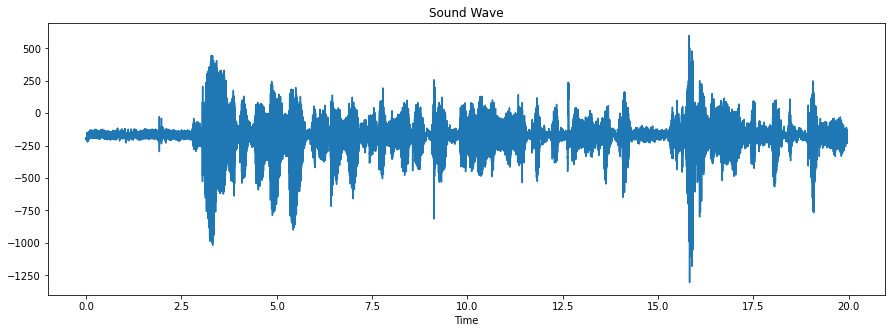

In [20]:
DV.visualize('../data/train_new/tr_10_tr01010.wav')

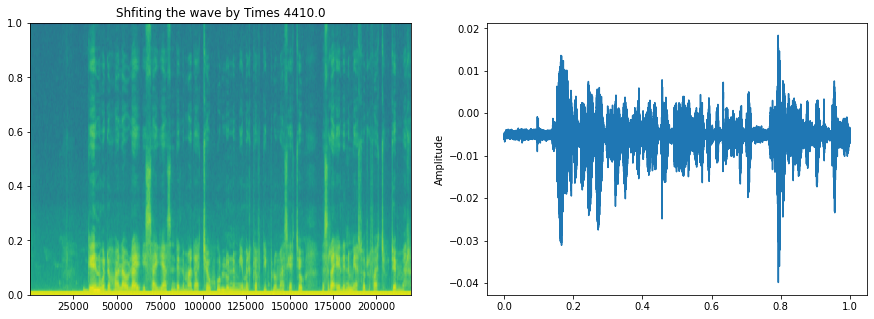

In [21]:
samples, sample_rate = librosa.load('../data/train_new/tr_10_tr01010.wav', sr=None)
DV.plot_spec(data=samples,sr=sample_rate)

## Data Splitting

In [22]:
# shuffling and splitting data

dfs = DC.split(meta_data, 80, 2)
train = dfs[0]
test = dfs[1]
print(train.shape)
print(test.shape)

(800, 5)
(200, 5)


### saving processed meta_data

In [25]:
# saving data as json

DC.meta_saver(train, "../data/train_meta.json", "json")
DC.meta_saver(test, "../data/test_meta.json", "json")

In [26]:
# loading and checking json data

test_df = DC.meta_loader("../data/train_meta.json", "json")
test_df.head()

,Target,Feature,Output,Duration,n_channel
0,የኤርትራ ወታደሮች ኢትዮጵያውያኑ ን ቀር ባ እንዳ ታይ ና እንዳታ ነጋገር...,../data/train/wav/tr_1025_tr11026.wav,../data/train_new/tr_1025_tr11026.wav,9.977324,2
1,በ ላቸው ም ነው እንዲ ህ ተ ንቆ ለ ጳ ጰ ሰ,../data/train/wav/tr_10602_tr04116.wav,../data/train_new/tr_10602_tr04116.wav,9.977324,2
2,ጣት ሽን አን ቋ ቂው ም አታንቋቂ ውም ማ ንም አላ የ ሽም,../data/train/wav/tr_10722_tr03139.wav,../data/train_new/tr_10722_tr03139.wav,9.977324,2
3,ባለሙያዎቹ በ ተጨማሪ ም እነዚህ ዲ ቃሎች የ ኢኮሎጂ መዛባት ሊያ ስከትሉ...,../data/train/wav/tr_10171_tr099013.wav,../data/train_new/tr_10171_tr099013.wav,9.977324,2
4,አ በ በ ለ ዶክተሩ ሁለመና ዬን ነው የሚያመ ኝ ብሎ ነገረው,../data/train/wav/tr_10800_tr02123.wav,../data/train_new/tr_10800_tr02123.wav,9.977324,2
